<a href="https://colab.research.google.com/github/StevenXiangluZhu/DNN_non-parametric_regression/blob/main/Non_parametricRegressionViaNeuralNetworkSimulationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

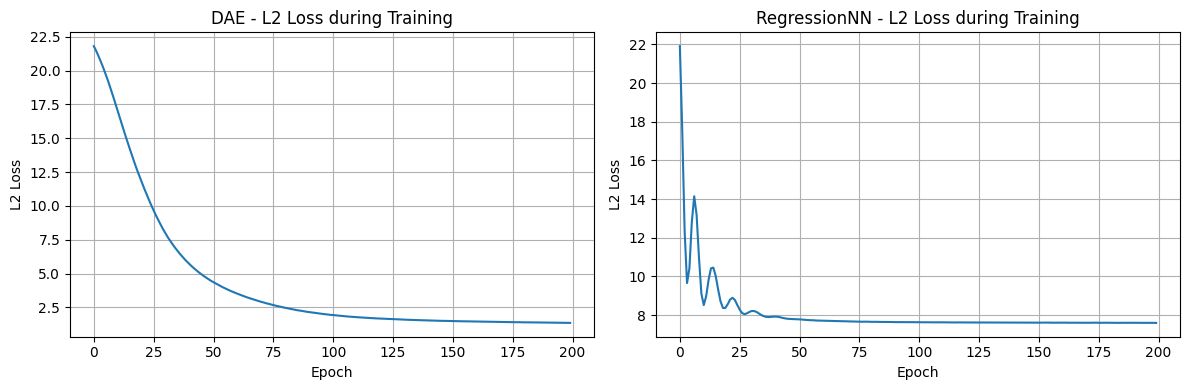

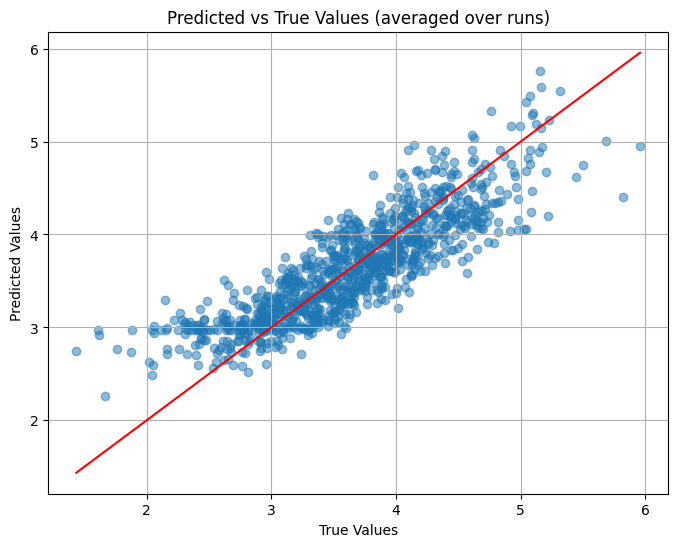

Average L2 Regression Risk over 100 runs: 0.14980327438826588


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

class support:
    def fun(self, x):
        return np.sum(np.sin(x))

    def find_risk(self, X_test, y_predict):
        ans = 0
        for i in range(len(y_predict)):
            ans += (self.fun(X_test[i]) - y_predict[i])**2
        return ans

class gen_data:
    def __init__(self, d, N, epsilon):
        self.d = d
        self.N = N
        self.epsilon = epsilon

    def fun(self, x):
        return support().fun(x)

    def generate(self):
        X = np.random.uniform(0, 1, self.N * self.d).reshape((self.N, self.d))
        y = [self.fun(X[i]) + np.random.normal(0, self.epsilon) for i in range(self.N)]
        return [X, np.array(y)]

    def generate_test_X(self, nn):
        return np.random.uniform(0, 1, nn * self.d).reshape((nn, self.d))

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

criterion_dae = nn.MSELoss()

def train_dae(model, data, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion_dae(outputs, data)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

criterion_nn = nn.MSELoss()

# Training the Regression Neural Network with loss recording
def train_nn_with_loss_recording(model, X, y, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients
        outputs = model(X).squeeze()
        loss = criterion_nn(outputs, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return losses

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(50, 25),
            nn.BatchNorm1d(25),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(100, 1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class SimplifiedRegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(SimplifiedRegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)

dim = 8
sample_N = 10000
runs = 100
losses_dae_avg = np.zeros(200)
losses_nn_avg = np.zeros(200)
risks = []

for _ in range(runs):
    data_gen = gen_data(dim, sample_N, 3)
    data = data_gen.generate()

    X_tensor = to_tensor(data[0])
    y_noisy_tensor = to_tensor(data[1]).view(-1, 1)

    dae = DAE()
    optimizer_dae = optim.Adam(dae.parameters(), lr=0.001)
    scheduler_dae = optim.lr_scheduler.StepLR(optimizer_dae, step_size=30, gamma=0.7)
    losses_dae = train_dae(dae, y_noisy_tensor, optimizer_dae)
    losses_dae_avg += np.array(losses_dae)

    y_denoised = dae(y_noisy_tensor).detach()

    simplified_regressor = SimplifiedRegressionNN(dim)
    optimizer_nn_simplified = optim.SGD(simplified_regressor.parameters(), lr=0.01, momentum=0.9)
    scheduler_nn = optim.lr_scheduler.StepLR(optimizer_nn_simplified, step_size=30, gamma=0.7)
    losses_nn = train_nn_with_loss_recording(simplified_regressor, X_tensor, y_denoised.squeeze(), optimizer_nn_simplified)
    losses_nn_avg += np.array(losses_nn)

    X_test_tensor = to_tensor(data_gen.generate_test_X(1000))
    y_pred_simplified = simplified_regressor(X_test_tensor).detach().numpy()
    risk = support().find_risk(X_test_tensor.numpy(), y_pred_simplified.squeeze()) / len(y_pred_simplified)
    risks.append(risk)

losses_dae_avg /= runs
losses_nn_avg /= runs
avg_risk = np.mean(risks)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_dae_avg)
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('DAE - L2 Loss during Training')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses_nn_avg)
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('RegressionNN - L2 Loss during Training')
plt.grid(True)
plt.tight_layout()
plt.show()

y_true = [support().fun(x) for x in X_test_tensor.numpy()]
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_simplified, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')  # y=x line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values (averaged over runs)")
plt.grid(True)
plt.show()

print(f"Average L2 Regression Risk over {runs} runs:", avg_risk)


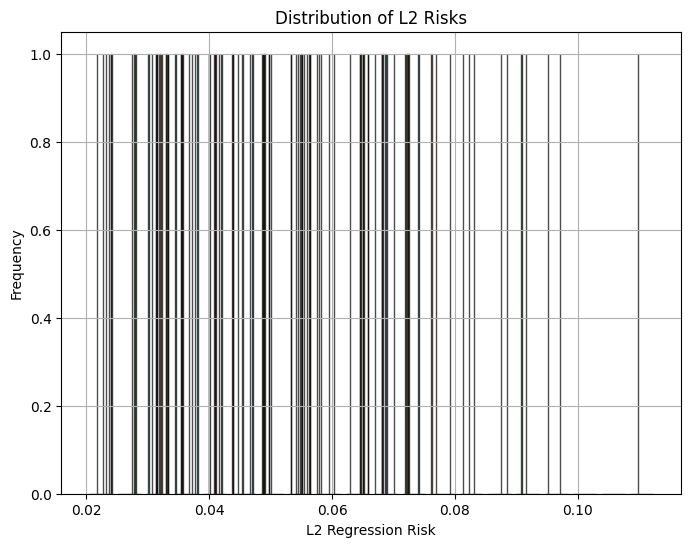

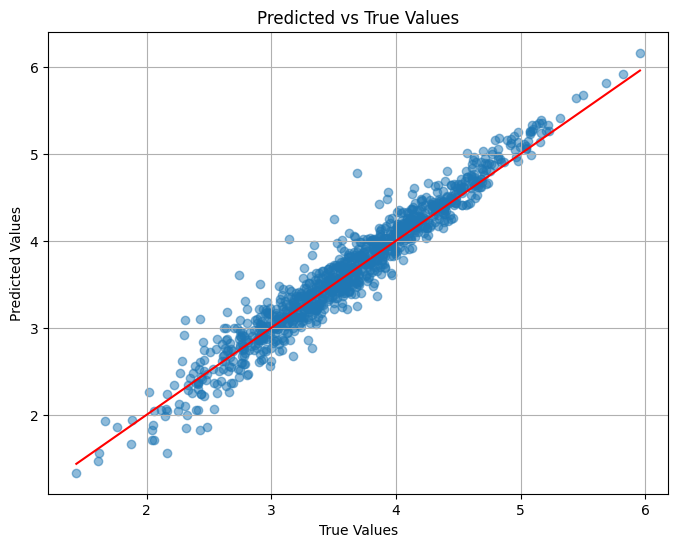

Average L2 Regression Risk over 100 runs: 0.052440092


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

class support:
    def fun(self, x):
        return np.sum(np.sin(x))

    def find_risk(self, X_test, y_predict):
        ans = 0
        for i in range(len(y_predict)):
            ans += (self.fun(X_test[i]) - y_predict[i])**2
        return ans

class gen_data:
    def __init__(self, d, N, epsilon):
        self.d = d
        self.N = N
        self.epsilon = epsilon

    def fun(self, x):
        return support().fun(x)

    def generate(self):
        X = np.random.uniform(0, 1, self.N * self.d).reshape((self.N, self.d))
        y = [self.fun(X[i]) + np.random.normal(0, self.epsilon) for i in range(self.N)]
        return [X, np.array(y)]

    def generate_test_X(self, nn):
        return np.random.uniform(0, 1, nn * self.d).reshape((nn, self.d))

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

class SimplifiedRegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(SimplifiedRegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)

criterion_nn = nn.MSELoss()

def train_nn_with_loss_recording(model, X, y, optimizer, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X).squeeze()
        loss = criterion_nn(outputs, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return losses

dim = 8
sample_N = 10000
runs = 100
risks = []
all_training_data = []
all_test_data = []

for run in range(runs):
    data_gen = gen_data(dim, sample_N, 3)
    data = data_gen.generate()

    X_tensor = to_tensor(data[0])
    y_noisy_tensor = to_tensor(data[1])

    simplified_regressor = SimplifiedRegressionNN(dim)
    optimizer = optim.Adam(simplified_regressor.parameters(), lr=0.003)
    train_nn_with_loss_recording(simplified_regressor, X_tensor, y_noisy_tensor, optimizer)

    X_test_tensor = to_tensor(data_gen.generate_test_X(1000))
    y_pred = simplified_regressor(X_test_tensor).detach().numpy()
    risk = support().find_risk(X_test_tensor.numpy(), y_pred) / len(y_pred)
    risks.append(risk)

    training_data_run = np.hstack((data[0], data[1].reshape(-1,1), np.array([run] * sample_N).reshape(-1, 1)))
    all_training_data.append(training_data_run)

    test_data_with_risk = np.hstack((X_test_tensor.numpy(), y_pred.reshape(-1,1), np.array([risk] * len(y_pred)).reshape(-1, 1), np.array([run] * len(y_pred)).reshape(-1, 1)))
    all_test_data.append(test_data_with_risk)

np.savetxt("all_training_data.txt", np.vstack(all_training_data))
np.savetxt("all_test_data.txt", np.vstack(all_test_data))

plt.figure(figsize=(8, 6))
plt.hist(risks, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('L2 Regression Risk')
plt.ylabel('Frequency')
plt.title('Distribution of L2 Risks')
plt.grid(True)
plt.show()

y_true = [support().fun(x) for x in X_test_tensor.numpy()]
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()

print(f"Average L2 Regression Risk over {runs} runs:", np.mean(risks))


In [4]:
from google.colab import files
files.download('all_training_data.txt')
files.download('all_test_data.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>